#📌 Extracão

In [ ]:
import pandas as pd

df = pd.read_json('TelecomX_Data.json')
df.to_csv('TelecomX_Data.csv', index=False)
head = df.head(10)
print(head)

#🔧 Transformação

In [ ]:
# ...após carregar o DataFrame df...

# Separar os dicionários de cada coluna em colunas individuais
customer_df = pd.json_normalize(df['customer'])
phone_df = pd.json_normalize(df['phone'])
internet_df = pd.json_normalize(df['internet'])
account_df = pd.json_normalize(df['account'])

# Concatenar as novas colunas ao DataFrame original (removendo as antigas)
df = pd.concat([
    df.drop(['customer', 'phone', 'internet', 'account'], axis=1),
    customer_df, phone_df, internet_df, account_df
], axis=1)

# Visualizar as primeiras linhas para conferir o resultado
display(df.head())

In [ ]:
# Selecionando novas colunas relevantes com base em variáveis numéricas e de serviço
colunas_relevantes = [
    'Churn',                # variável alvo
    'Charges.Monthly',       # valor mensal cobrado
    'Charges.Total',         # valor total cobrado
    'tenure',               # tempo de permanência (em meses)
    'InternetService',      # tipo de internet
    'OnlineSecurity',       # segurança online
    'TechSupport',          # suporte técnico
    'Contract',             # tipo de contrato
    'PaymentMethod',        # forma de pagamento
    'SeniorCitizen',        # cliente idoso
]

# Filtrar o DataFrame para manter apenas essas colunas (se existirem)
colunas_existentes = [col for col in colunas_relevantes if col in df.columns]
df = df[colunas_existentes]

print("\nNovas colunas selecionadas para análise de evasão:")
print(colunas_existentes)
display(df.head())

In [ ]:
# Separando cada coluna relevante em uma variável individual
churn = df['Churn']
tenure = df['tenure']
contract = df['Contract']
payment_method = df['PaymentMethod']
charges_monthly = df['Charges.Monthly']
charges_total = df['Charges.Total']
internet_service = df['InternetService']
online_security = df['OnlineSecurity']
tech_support = df['TechSupport']
senior_citizen = df['SeniorCitizen']


# Função para análise individual de cada variável
def analisar_variavel(nome, serie):
    print(f"\n--- {nome} ---")
    print("Valores ausentes:", serie.isnull().sum())
    print("Valores duplicados:", serie.duplicated().sum())
    print("Tipo de dado:", serie.dtype)
    print("Valores únicos:", serie.unique())
    print("Quantidade de valores únicos:", serie.nunique())
    print("Exemplo de valores:", serie.value_counts().head())

# Aplicando a análise para cada variável
analisar_variavel('Churn', churn)
analisar_variavel('Tenure', tenure)
analisar_variavel('Contract', contract)
analisar_variavel('PaymentMethod', payment_method)
analisar_variavel('Charges.Monthly', charges_monthly)
analisar_variavel('Charges.Total', charges_total)
analisar_variavel('InternetService', internet_service)
analisar_variavel('OnlineSecurity', online_security)
analisar_variavel('TechSupport', tech_support)
analisar_variavel('SeniorCitizen', senior_citizen)


In [ ]:
# Tratamento dos dados com base na análise exploratória

# 1. Churn: remover registros com valor em branco ('')
df = df[df['Churn'].str.strip() != '']

# 2. Charges.Total: converter para float e tratar possíveis valores em branco
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')

# 3. OnlineSecurity e TechSupport: tratar 'No internet service' como 'No'
df['OnlineSecurity'] = df['OnlineSecurity'].replace({'No internet service': 'No'})
df['TechSupport'] = df['TechSupport'].replace({'No internet service': 'No'})

# 4. SeniorCitizen: converter 0 para 'No' e 1 para 'Yes'
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# 5. (Opcional) Remover possíveis valores em branco em Charges.Total após conversão
df = df[~df['Charges.Total'].isnull()]

# 6. Resetar o índice após remoções
df = df.reset_index(drop=True)

print("Tratamento de dados realizado. Pronto para análise!")
display(df.head())

In [ ]:
# Criar a coluna "Contas_Diarias" usando o faturamento mensal dividido por 30
df['Contas_Diarias'] = df['Charges.Monthly'] / 30

print("Coluna 'Contas_Diarias' criada com sucesso!")
display(df[['Charges.Monthly', 'Contas_Diarias']].head())

#📊 Carga e análise

In [ ]:
# Análise descritiva das principais colunas numéricas
print("Análise descritiva das variáveis numéricas:")
print(df.describe())

# Para colunas categóricas, mostrar a distribuição dos valores
colunas_categoricas = ['Churn', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaymentMethod', 'SeniorCitizen']
for col in colunas_categoricas:
    if col in df.columns:
        print(f"\nDistribuição de valores para '{col}':")
        print(df[col].value_counts())

In [ ]:
import matplotlib.pyplot as plt

# Gráfico de pizza para proporção de churn
churn_counts = df['Churn'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66bb6a', '#ef5350'])
plt.title('Proporção de Clientes - Churn')
plt.axis('equal')
plt.show()

# Gráfico de barras para contagem absoluta
plt.figure(figsize=(6, 4))
churn_counts.plot(kind='bar', color=['#66bb6a', '#ef5350'])
plt.title('Contagem de Clientes por Churn')
plt.xlabel('Churn')
plt.ylabel('Quantidade de Clientes')
plt.xticks(rotation=0)
plt.show()

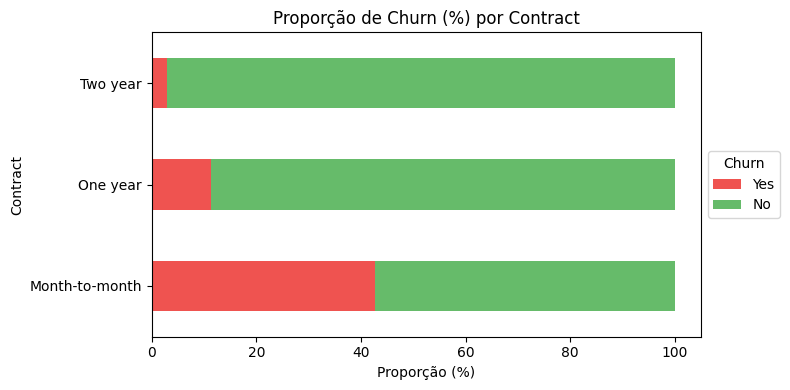

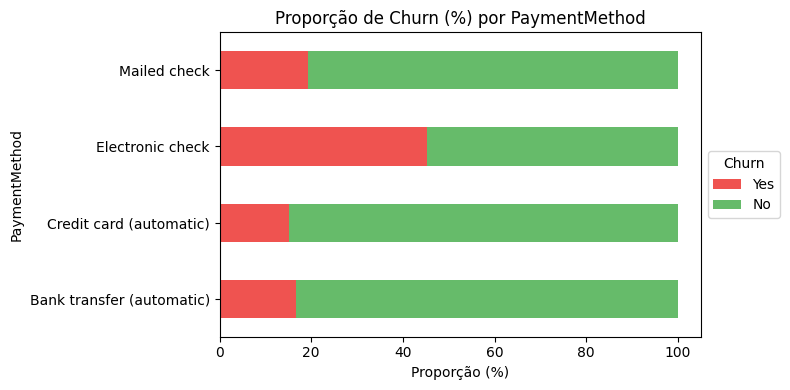

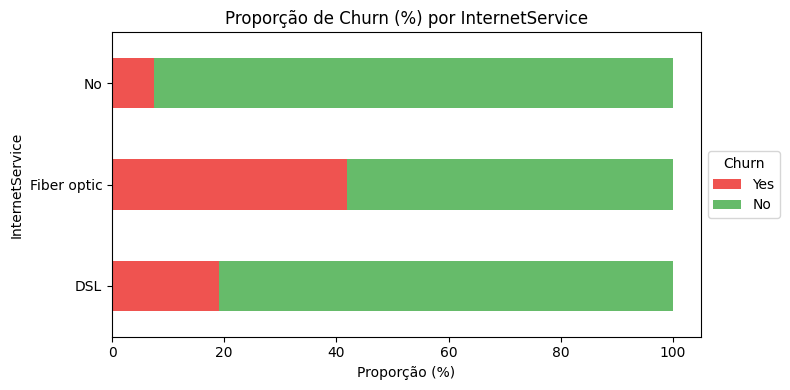

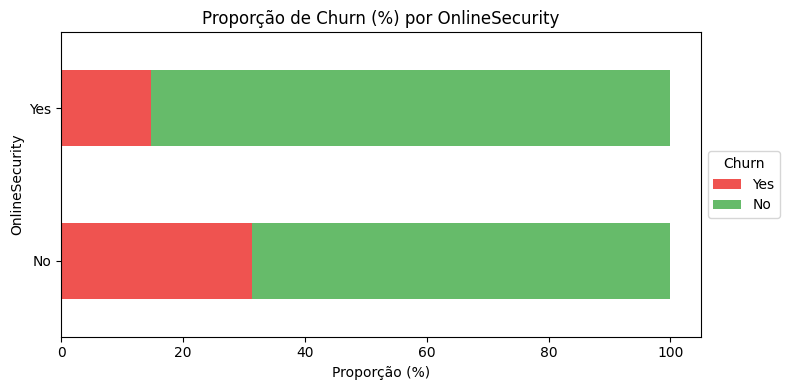

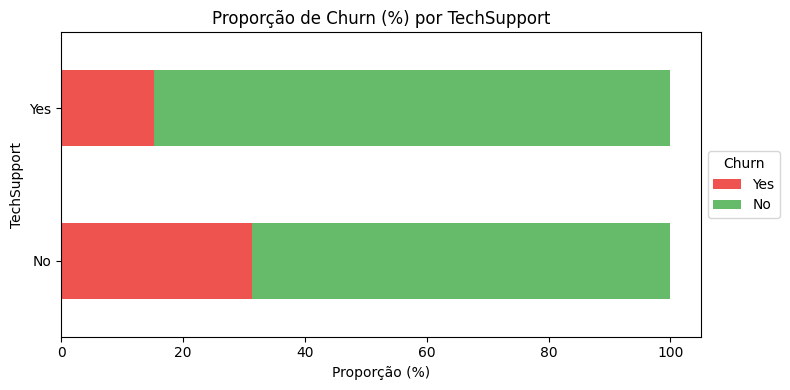

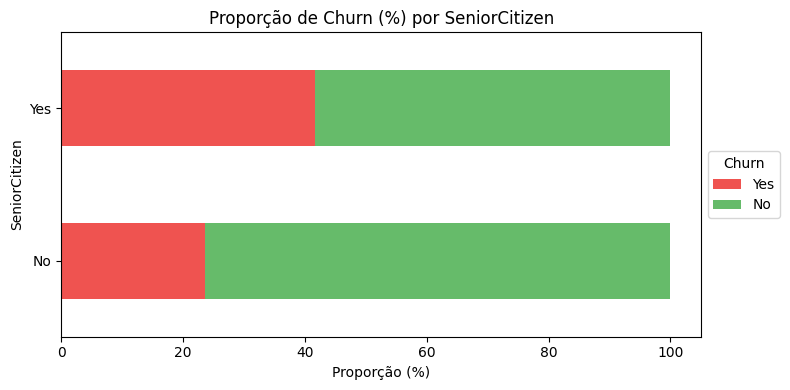

In [ ]:
# Gráficos de barras horizontais para proporção de churn por categoria

variaveis_categoricas = [
    'gender', 'Contract', 'PaymentMethod', 'InternetService',
    'OnlineSecurity', 'TechSupport', 'SeniorCitizen'
]

for var in variaveis_categoricas:
    if var in df.columns:
        cross = df.groupby([var, 'Churn']).size().unstack(fill_value=0)
        cross_percent = cross.div(cross.sum(axis=1), axis=0) * 100  # porcentagem por categoria
        cross_percent[['Yes', 'No']].plot(kind='barh', stacked=True, color=['#ef5350', '#66bb6a'], figsize=(8, 4))
        plt.title(f'Proporção de Churn (%) por {var}')
        plt.xlabel('Proporção (%)')
        plt.ylabel(var)
        plt.legend(title='Churn', loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()

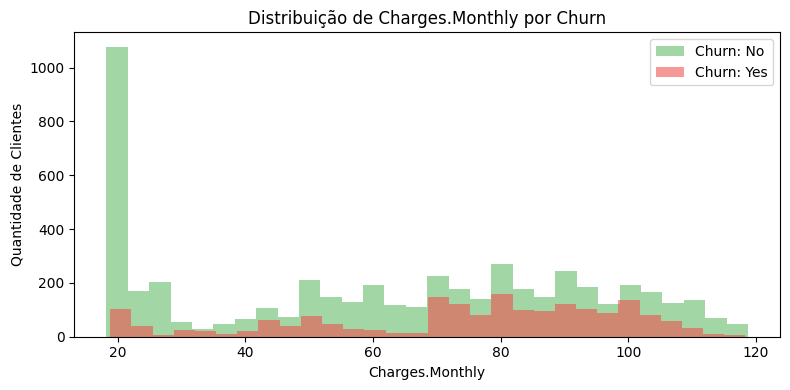

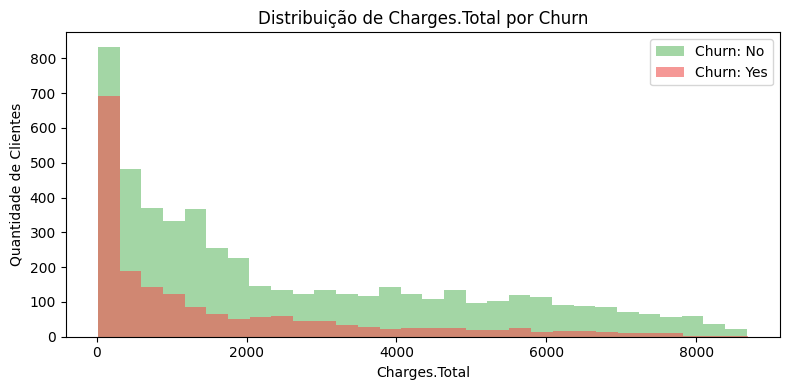

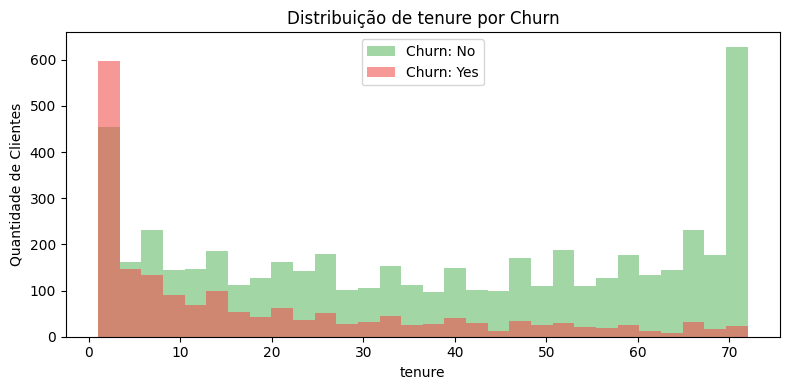

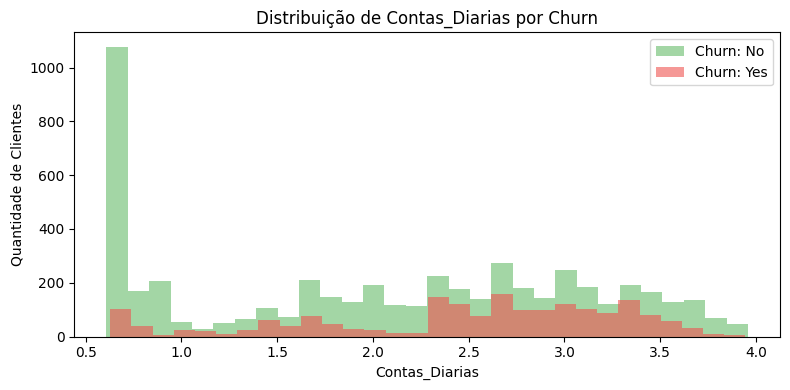

In [11]:
# Análise da distribuição de variáveis numéricas por churn

variaveis_numericas = ['Charges.Monthly', 'Charges.Total', 'tenure', 'Contas_Diarias']

for var in variaveis_numericas:
    if var in df.columns:
        plt.figure(figsize=(8, 4))
        for churn_status, cor in zip(['No', 'Yes'], ['#66bb6a', '#ef5350']):
            subset = df[df['Churn'] == churn_status]
            plt.hist(subset[var], bins=30, alpha=0.6, label=f'Churn: {churn_status}', color=cor)
        plt.title(f'Distribuição de {var} por Churn')
        plt.xlabel(var)
        plt.ylabel('Quantidade de Clientes')
        plt.legend()
        plt.tight_layout()
        plt.show()

#📄Relatorio Final

#📄 Relatório Final

## 1. Introdução

O objetivo deste trabalho foi analisar o problema de evasão de clientes (churn) em uma empresa de telecomunicações. A evasão de clientes representa um grande desafio para o setor, pois impacta diretamente a receita e a sustentabilidade do negócio. Compreender os fatores que levam os clientes a cancelar seus serviços é fundamental para criar estratégias de retenção mais eficazes.

---

## 2. Limpeza e Tratamento de Dados

- **Importação:** Os dados foram importados de um arquivo JSON e convertidos para CSV para facilitar a manipulação.
- **Estruturação:** As colunas com informações em formato JSON foram normalizadas, separando cada atributo em colunas distintas.
- **Seleção de Variáveis:** Foram selecionadas apenas as colunas mais relevantes para a análise de churn, focando em variáveis numéricas e de serviço.
- **Tratamento de Dados:**
  - Remoção de registros com valores ausentes ou em branco na variável alvo (`Churn`).
  - Conversão de colunas numéricas para o tipo adequado.
  - Padronização de categorias, como transformar `No internet service` em `No` e converter `SeniorCitizen` para valores categóricos (`Yes`/`No`).
  - Criação da coluna `Contas_Diarias` para analisar o valor diário gasto pelo cliente.

---

## 3. Análise Exploratória de Dados

### 3.1. Análise Descritiva

- Foram calculadas métricas como média, mediana e desvio padrão das principais variáveis numéricas.
- As distribuições das variáveis categóricas foram apresentadas para entender o perfil dos clientes.

### 3.2. Visualização da Evasão

- **Gráfico de Pizza:** Mostrou a proporção de clientes que permaneceram e os que cancelaram.
- **Gráfico de Barras:** Apresentou a contagem absoluta de clientes por status de churn.

### 3.3. Evasão por Perfil

- Foram analisadas as proporções de churn em diferentes categorias, como tipo de contrato, método de pagamento, serviço de internet, entre outros.
- Gráficos de barras horizontais evidenciaram quais perfis têm maior tendência à evasão.

### 3.4. Evasão por Variáveis Numéricas

- Foram exploradas as distribuições de variáveis como `Charges.Monthly`, `Charges.Total`, `tenure` e `Contas_Diarias` entre clientes que cancelaram e os que permaneceram.
- Observou-se que clientes com menor tempo de contrato e menor valor total gasto tendem a apresentar maior evasão.

---

## 4. Conclusões e Insights

- **Tempo de Contrato:** Clientes com menor tempo de permanência (tenure) apresentam maior taxa de churn, indicando que os primeiros meses são críticos para retenção.
- **Tipo de Contrato:** Contratos mensais têm maior evasão em comparação com contratos anuais ou bienais.
- **Serviços Adicionais:** A ausência de serviços como segurança online e suporte técnico está associada a maior churn.
- **Perfil de Pagamento:** Métodos de pagamento automáticos estão relacionados a menor evasão.
- **Valor Gasto:** Clientes que gastam menos mensalmente ou no total tendem a cancelar mais.

---

## 5. Recomendações

- **Foco na Retenção Inicial:** Desenvolver ações específicas para clientes nos primeiros meses de contrato, como ofertas e acompanhamento personalizado.
- **Incentivo a Contratos Longos:** Oferecer benefícios para migração de contratos mensais para anuais ou bienais.
- **Promoção de Serviços Adicionais:** Incentivar a adesão a serviços de segurança online e suporte técnico.
- **Facilitar Pagamentos Automáticos:** Estimular o uso de métodos de pagamento automáticos, reduzindo barreiras para o cliente.
- **Monitoramento Contínuo:** Implementar sistemas de monitoramento para identificar rapidamente clientes com alto risco de churn e agir preventivamente.

---

**Essas análises e recomendações podem ajudar a empresa a direcionar melhor suas estratégias de retenção, reduzindo a evasão e aumentando a satisfação dos clientes.**